In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import tensorflow as tf
from tensorflow.keras import optimizers, models, Model, applications, metrics
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Flatten, Dense, Reshape, Concatenate, Conv2DTranspose, ReLU, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, TensorBoard
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import tensorflow.keras.utils as utils

In [2]:
from google.colab import drive
from google.colab import files 


drive.mount("/content/gdrive")
print(os.getcwd())
os.chdir("/content/gdrive/My Drive/AML2021/AML2021")
print(os.getcwd())

Mounted at /content/gdrive
/content
/content/gdrive/.shortcut-targets-by-id/1_nr6od538RmnZRE1gB6vQYFsrHaUgS19/AML2021/AML2021


# Feature Pyramid Auto Encoder

In [ ]:
INITIAL_EPOCH = 0
NUM_EPOCHS = 120
BATCH_SIZE = 16
INPUT_SHAPE = (299,299,1)
CLASSES = 2
VAL_SPLIT=0.2
os.makedirs('models/FPAE', exist_ok = True) 
os.makedirs('models/FPAE/imgs', exist_ok = True)

## Model

In [ ]:
# Encoder, Decoder from https://www.medrxiv.org/content/10.1101/2020.04.14.20065722v1.full.pdf
def blockT(i, lateral_i, filter, kernel, strides=(2,2), padding='same'):
  x = Conv2DTranspose(filter, kernel, strides=strides, padding=padding)(i)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  lateral_connection = Conv2D(filter, (1,1), strides=(1,1), padding='same')(lateral_i)
  x = Concatenate(axis=-1)([x, lateral_connection])
  return x

def block(i, filter, kernel, strides=(2,2), padding='same'):
  x = Conv2D(filter, kernel, strides=strides, padding=padding)(i)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  return x

def create_AE(name):
  #encoder
  x = Input(shape=INPUT_SHAPE)
  l1 = block(x, 64, (4,4), strides=(2,2), padding='valid')
  l2 = block(l1, 64, (3,3), strides=(1,1), padding='same')
  l3 = block(l2, 128, (3,3), strides=(2,2), padding='same')
  l4 = block(l3, 128, (3,3), strides=(1,1), padding='same')
  l5 = block(l4, 256, (3,3), strides=(2,2), padding='valid')
  l6 = block(l5, 256, (3,3), strides=(1,1), padding='same')
  l7 = block(l6, 512, (3,3), strides=(2,2), padding='same')
  l = Flatten()(l7)
  z = Dense(81)(l) #LATENT_DIM is 9*9=81

  #decoder
  l = Reshape((9,9,1))(z)
  l = blockT(l, l7, 256, (3,3), strides=(2,2), padding='same')#18x18x512
  l = block(l, 256, (3,3), strides=(1,1), padding='same')
  l = blockT(l, l5, 128, (3,3), strides=(2,2), padding='same')#36x36x256
  l = blockT(l, l3, 64, (4,4), strides=(2,2), padding='valid')#74x74x128
  l = block(l, 64, (3,3), strides=(1,1), padding='same')
  l = blockT(l, l1, 32, (3,3), strides=(2,2), padding='same')#148x148x64
  x_recon = Conv2DTranspose(1, (5,5), strides=(2,2), padding='valid')(l)#299x299x1
  
  return Model(x,x_recon, name=name)

## Training

In [ ]:
# load data
x_train = np.load("x_train.npy")[:,:,:,0:1]
y_train = np.load("y_train.npy")

x_cov_idx = np.where(y_train[:,0]==1)[0]
x_normal_idx = np.where(y_train[:,1]==1)[0]

print(x_train.shape, y_train.shape)

(16324, 299, 299, 1) (16324, 2)


In [ ]:
# Train FPAE_Normal
OPTIMIZER = optimizers.Adam(learning_rate=1e-4)
NAME = "FPAE_Normal"
LRS = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001)
ES = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

MC_BEST = ModelCheckpoint(f'models/FPAE/best-{NAME}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")
LOG = CSVLogger(f'models/FPAE/{NAME}.log')
TB = TensorBoard(log_dir=f'models/FPAE/tb-logs')

model = create_AE(NAME)
model.compile(optimizer=OPTIMIZER, loss='mean_squared_error')
model.fit(x=x_train[x_normal_idx], y=x_train[x_normal_idx], batch_size=BATCH_SIZE, validation_split = VAL_SPLIT, callbacks = [MC_BEST, LRS, ES, LOG, TB], epochs = NUM_EPOCHS, initial_epoch = INITIAL_EPOCH)

In [ ]:
# Train FPAE_Cov
OPTIMIZER = optimizers.Adam(learning_rate=1e-4)
NAME = "FPAE_Cov"
LRS = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001)
ES = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

MC_BEST = ModelCheckpoint(f'models/FPAE/best-{NAME}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")
LOG = CSVLogger(f'models/FPAE/{NAME}.log')
TB = TensorBoard(log_dir=f'models/FPAE/tb-logs')

# Train FPAE_Cov
model = create_AE(NAME)
model.compile(optimizer=OPTIMIZER, loss='mean_squared_error')
model.fit(x=x_train[x_cov_idx], y=x_train[x_cov_idx], batch_size=BATCH_SIZE, validation_split = VAL_SPLIT, callbacks = [MC_BEST, LRS, ES, LOG, TB], epochs = NUM_EPOCHS, initial_epoch = INITIAL_EPOCH)

# Classifier

In [ ]:
# load data
x_train = np.load("x_train.npy")[:,:,:,0:1]
y_train = np.load("y_train.npy")

print(x_train.shape, y_train.shape)

(16324, 299, 299, 1) (16324, 2)


In [ ]:
INITIAL_EPOCH = 0
NUM_EPOCHS = 120
BATCH_SIZE = 32
INPUT_SHAPE = (299,299,1)
CLASSES = 2
OPTIMIZER = optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=False)
NAME = "CLS"
LRS = ReduceLROnPlateau(monitor='val_auroc', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001)
ES = EarlyStopping(monitor='val_auroc', min_delta=0.0001, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

MC_BEST = ModelCheckpoint(f'models/FPAE/best-{NAME}.hdf5', monitor='val_auroc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")
LOG = CSVLogger(f'models/FPAE/{NAME}.log')
TB = TensorBoard(log_dir=f'models/FPAE/{NAME}-tb-logs')

METRICS = [metrics.AUC(name='auroc', curve='ROC'),
           metrics.CategoricalAccuracy(name='accuracy'),
           metrics.Precision(name='precision'),
           metrics.Recall(name='recall')
           ]

In [ ]:
def create_cls(name):
  FPAE_norm = models.load_model("models/FPAE/best-FPAE_Normal.hdf5")
  FPAE_cov = models.load_model("models/FPAE/best-FPAE_Cov.hdf5")

  FPAE_norm.trainable = False
  FPAE_cov.trainable = False

  x = Input(shape=INPUT_SHAPE)# shape should be None, 299, 299, 1 for greyscale
  x_recon_cov = FPAE_cov(x)
  x_recon_normal = FPAE_norm(x)

  x_0 = tf.abs(x-x_recon_cov)
  x_1 = tf.abs(x-x_recon_normal)
  x_2 = tf.abs(2*x-x_recon_normal)
  l = Concatenate(axis=-1)([x_0,x_1,x_2])# now shape should be None, 299, 299, 3

  l = applications.resnet.preprocess_input(l)
  base_model = applications.ResNet50(include_top=False, weights="imagenet", input_shape=(299,299,3))
  l = base_model(l)
  l = GlobalAveragePooling2D(name='avg_pool')(l)
  y = Dense(CLASSES, activation='softmax', name=f'fc{CLASSES}')(l)
  return Model(x,y, name=name)

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                       y_train: 255.2 KiB
                          _iii:  1.7 KiB
                           _i3:  1.7 KiB
                         Model:  1.0 KiB
                        Conv2D:  1.0 KiB
            BatchNormalization:  1.0 KiB
                       Flatten:  1.0 KiB
                         Dense:  1.0 KiB
                       Reshape:  1.0 KiB
                   Concatenate:  1.0 KiB


In [ ]:
model = create_cls(NAME)
model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=METRICS)
model.fit(x=x_train, y=y_train, batch_size=8, validation_split = 0.2, callbacks = [MC_BEST, LRS, ES, LOG, TB], epochs = NUM_EPOCHS, initial_epoch = INITIAL_EPOCH)

Epoch 1/120
1633/1633 [==============================] - 420s 250ms/step - loss: 1.7010 - auroc: 0.5556 - accuracy: 0.5290 - precision: 0.5290 - recall: 0.5290 - val_loss: 0.6475 - val_auroc: 0.5743 - val_accuracy: 0.5219 - val_precision: 0.5219 - val_recall: 0.5219

Epoch 00001: val_auroc improved from inf to 0.57428, saving model to models/FPAE\best-CLS.hdf5
Epoch 2/120
1633/1633 [==============================] - 408s 250ms/step - loss: 0.6677 - auroc: 0.6034 - accuracy: 0.5683 - precision: 0.5683 - recall: 0.5683 - val_loss: 1.5082 - val_auroc: 0.4709 - val_accuracy: 0.4459 - val_precision: 0.4459 - val_recall: 0.4459

Epoch 00002: val_auroc improved from 0.57428 to 0.47088, saving model to models/FPAE\best-CLS.hdf5
Epoch 3/120
1633/1633 [==============================] - 402s 246ms/step - loss: 0.6628 - auroc: 0.6098 - accuracy: 0.5687 - precision: 0.5687 - recall: 0.5687 - val_loss: 0.6407 - val_auroc: 0.5962 - val_accuracy: 0.5311 - val_precision: 0.5311 - val_recall: 0.5311

Ep

In [ ]:
NAME= "CLS"
BATCH_SIZE=32

# Eval Model
x_test = np.load("x_test.npy")[:,:,:,0:1]
y_test = np.load("y_test.npy")

model = models.load_model(f'models/FPAE/best-{NAME}.hdf5', compile=True)
out = model.evaluate(x=x_test, y=y_test, batch_size=BATCH_SIZE, verbose=1)

# Save Results
with open("results.txt","a+") as f:
  f.write(f"{NAME} test_loss: {out[0]}, test_auroc: {out[1]}, test_acc: {out[2]}, test_prec: {out[3]}, test_rec: {out[4]}, test_f1: {2* ((out[3]*out[4]) / (out[3]+out[4]))}\n")
print(f"wrote \"{NAME} test_loss: {out[0]}, test_auroc: {out[1]}, test_acc: {out[2]}, test_prec: {out[3]}, test_rec: {out[4]}, test_f1: {2* ((out[3]*out[4]) / (out[3]+out[4]))}\n\" to results.txt ")

87/87 [==============================] - 108s 825ms/step - loss: 2.1499 - auroc: 0.4175 - accuracy: 0.4879 - precision: 0.4879 - recall: 0.4879
wrote "CLS test_loss: 2.1499359607696533, test_auroc: 0.41746461391448975, test_acc: 0.48787549138069153, test_prec: 0.48787549138069153, test_rec: 0.48787549138069153, test_f1: 0.48787549138069153
" to results.txt 


# Output

In [17]:
from matplotlib import pyplot as plt
x_test = np.load("x_test.npy")[0:1,:,:,0:1]

#model = models.load_model(f'models/FPAE/best-FPAE_Normal.hdf5', compile=True)
model = models.load_model(f'models/FPAE/best-FPAE_Cov.hdf5', compile=True)
out = model.predict(x_test)



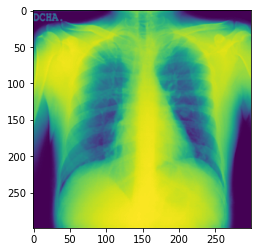

In [18]:
plt.imshow(x_test[0,:,:,0])
plt.show()
plt.imsave('Cov.png', x_test[0,:,:,0])

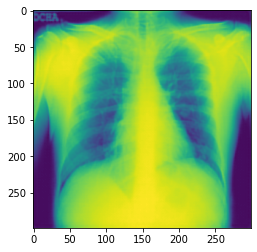

In [19]:
plt.imshow(out[0,:,:,0])
plt.show()
plt.imsave('AutoencodedCov.png', out[0,:,:,0])